In [52]:
%matplotlib inline

import pickle

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Scikit imports
from sklearn.datasets import make_classification, make_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [41]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [42]:
# functions
def build_prob_plot(probas, title):
    """Builds sns.distplots for the given probabilities.
    
    Args:
        probas (np.ndarray): probabilities to plot
        title (str)
    """

    fig, axes = plt.subplots(5,4, figsize=(10,10), sharex=True)
    axes = axes.flat
    for idx, prob in enumerate(probas):
        # TODO parameterize this later
        axes[idx].set(ylim=(0,3), title="k={}".format((idx + 1)*100))
        sns.distplot(prob, bins=np.arange(0, 1.1, 0.05), ax=axes[idx])

    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("P(y=1 | x)")
    plt.ylabel("density (area sums to 1)")
    plt.show()

# Overfitting in the Noise Case

## Setup

Let $D$ be the joint probability distribution on $\mathcal X \times \mathcal Y$, where $\mathcal X$ is the instance space and $\mathcal Y = \{0, 1\}$ the label space.


Assume the features $X$ are drawn from a multivariate normal distribution $\mathcal{N}$ with zero mean and unit variance.

Assume the labels $Y$ are drawn from a Bernoulli distribution with parameter $p$.

In this setting, the conditional probability of label $y=1$ for any given $x$ under $D$ is: $\eta(x) = P(y=1 | x) = p$ since $Y$ and $X$ are independent.

Thus the minimal achievable error associated with $D$ is $1-p$, and the Bayes optimal classifier $h^*(x)$ is predicting the majority class label (if $p=0.5$, pick one label to always predict or randomly pick a label to predict):

$$h^*(x) = \mathbb{1}[\eta(x) > 0.5] = \mathbb{1}[p > 0.5]$$

## Simulation

- \# of training samples: 500
- \# of testing samples: 500
- \# of features $k$: [100, 2000] in increments of 100
- two models:
    - logistic regression with no regularization
    - logistic regression with quadratic features and no regularization


#### Hypothesis
- we expect overfitting in both cases as $k$ increases, with the quadratic features overfitting more severely than the linear features
- we can verify this with visual inspection of the distribution of probabilities on the test set: as overfitting "increases," we should see deviations from a bimodal distribution with the two peaks centered around 0 and 1
- we can also examine the distance the test probabilities are from 0.5 (complete uncertainty), overfit models should have a smaller distance from 0.5

### p = 0.5

In [3]:
# load data
train_accs = pickle.load(open("../pkl/noise_class_train_acc.pkl", "rb"))
test_accs = pickle.load(open("../pkl/noise_class_test_acc.pkl", "rb"))
train_probas = pickle.load(open("../pkl/noise_class_train_proba.pkl", "rb"))
test_probas = pickle.load(open("../pkl/noise_class_test_proba.pkl", "rb"))

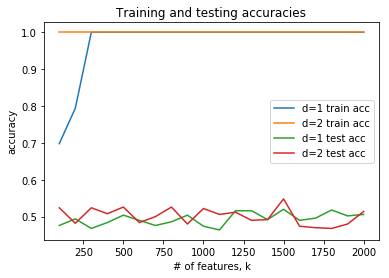

In [46]:
x = np.arange(100, 2001, 100)
sns.lineplot(x, train_accs[0], label="d=1 train acc")
sns.lineplot(x, train_accs[1], label="d=2 train acc")
sns.lineplot(x, test_accs[0], label="d=1 test acc")
sns.lineplot(x, test_accs[1], label="d=2 test acc")
plt.title("Training and testing accuracies")
plt.ylabel("accuracy")
plt.xlabel("# of features, k")
plt.show()

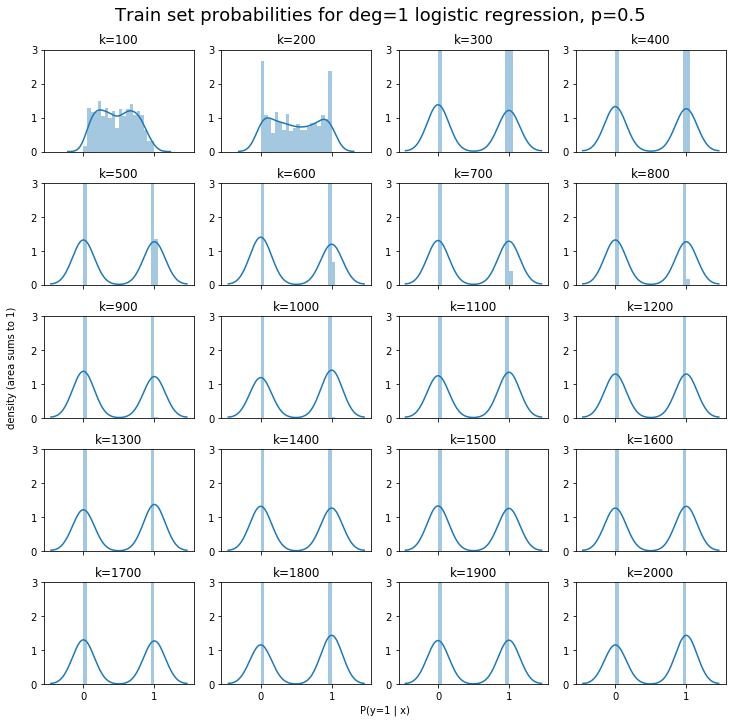

In [83]:
build_prob_plot(train_probas[0], "Train set probabilities for deg=1 logistic regression, p=0.5")

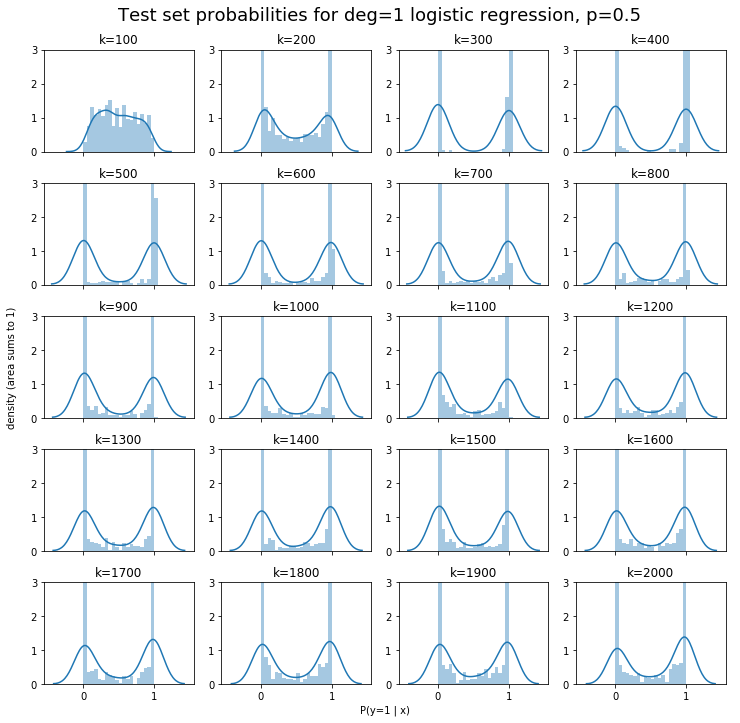

In [84]:
build_prob_plot(test_probas[0], "Test set probabilities for deg=1 logistic regression, p=0.5")

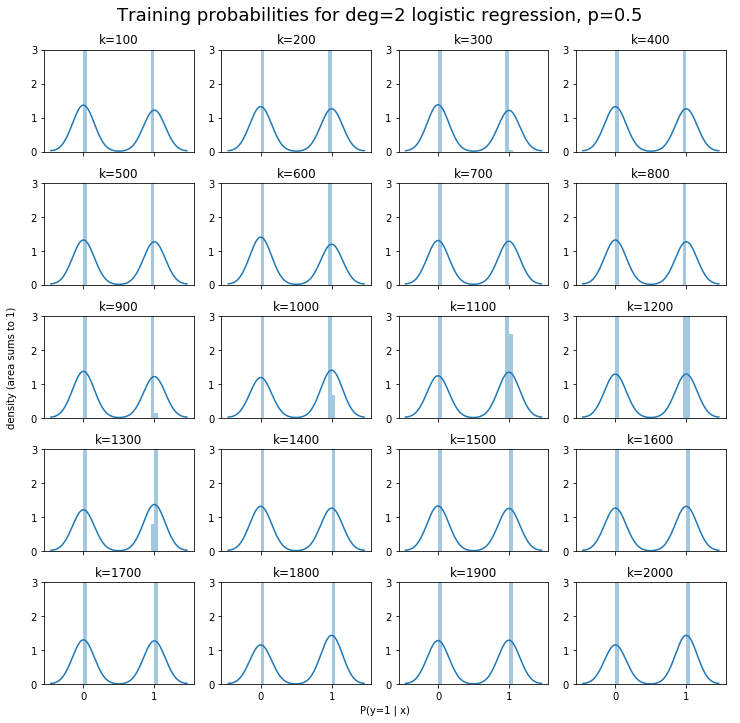

In [86]:
build_prob_plot(train_probas[1], "Training probabilities for deg=2 logistic regression, p=0.5")

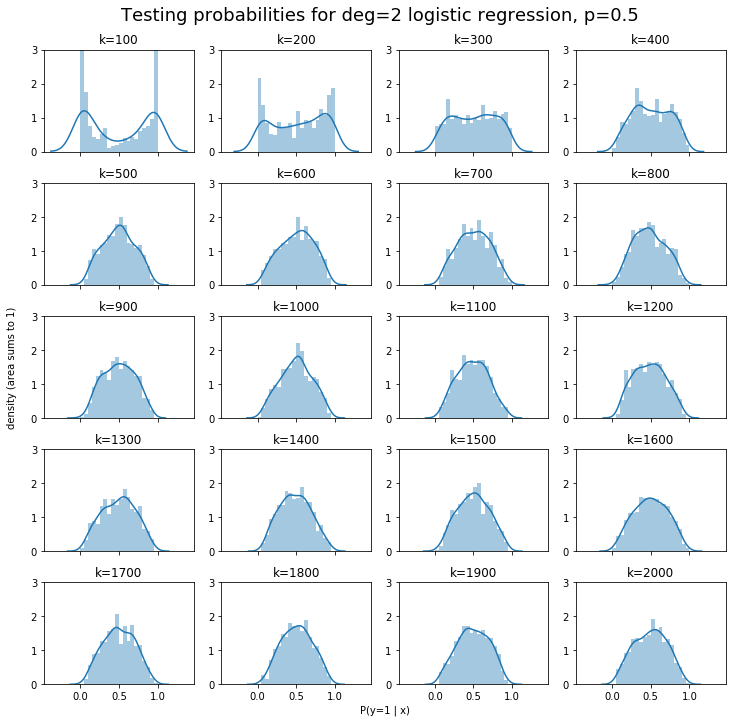

In [85]:
build_prob_plot(test_probas[1], "Testing probabilities for deg=2 logistic regression, p=0.5")

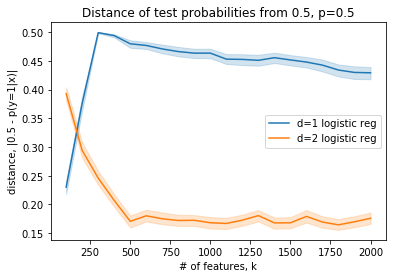

In [89]:
df = pd.DataFrame()
x = []
base_diffs = []
poly_diffs = []
for idx, k in enumerate(range(100, 2001, 100)):
    x = x + [k] * 500
    base_diffs.extend(list(np.abs(0.5 - test_probas[0][idx])))
    poly_diffs.extend(list(np.abs(0.5 - test_probas[1][idx])))

df['x'] = x
df['d1_diff'] = base_diffs
df['d2_diff'] = poly_diffs

sns.lineplot(x='x', y='d1_diff', data=df, label="d=1 logistic reg")
sns.lineplot(x='x', y='d2_diff', data=df, label="d=2 logistic reg")
plt.ylabel("distance, |0.5 - p(y=1|x)|")
plt.xlabel("# of features, k")
plt.title("Distance of test probabilities from 0.5, p=0.5")
plt.show()

### p = 0.2

In [76]:
# load data
skew_train_accs = pickle.load(open("../pkl/noise_class_skew_train_acc.pkl", "rb"))
skew_test_accs = pickle.load(open("../pkl/noise_class_skew_test_acc.pkl", "rb"))
skew_train_probas = pickle.load(open("../pkl/noise_class_skew_train_proba.pkl", "rb"))
skew_test_probas = pickle.load(open("../pkl/noise_class_skew_test_proba.pkl", "rb"))

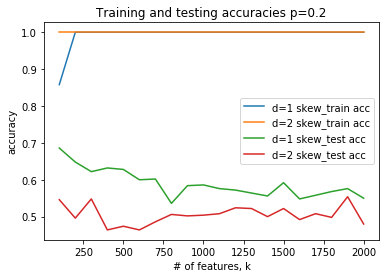

In [78]:
x = np.arange(100, 2001, 100)
sns.lineplot(x, skew_train_accs[0], label="d=1 skew_train acc")
sns.lineplot(x, skew_train_accs[1], label="d=2 skew_train acc")
sns.lineplot(x, skew_test_accs[0], label="d=1 skew_test acc")
sns.lineplot(x, skew_test_accs[1], label="d=2 skew_test acc")
plt.title("Training and testing accuracies p=0.2")
plt.ylabel("accuracy")
plt.xlabel("# of features, k")
plt.show()

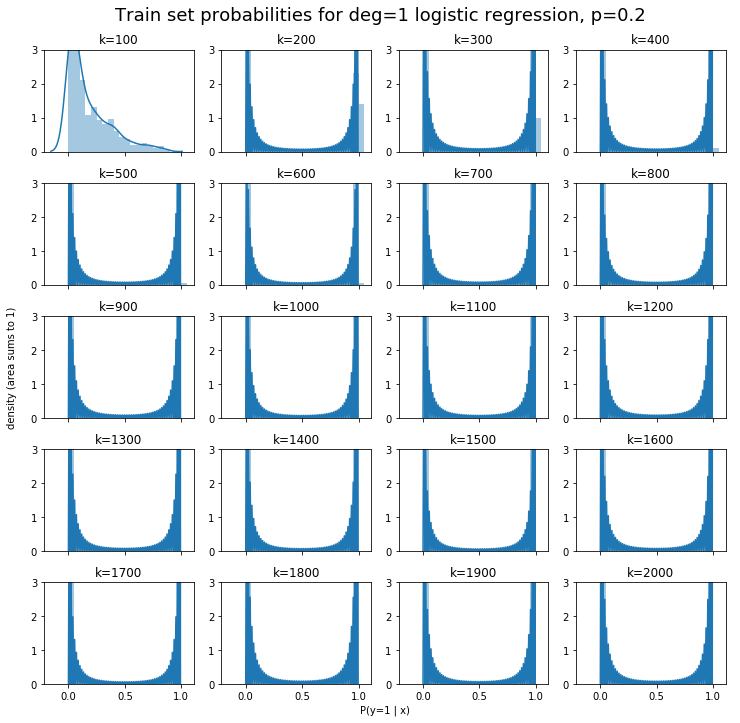

In [79]:
build_prob_plot(skew_train_probas[0], "Train set probabilities for deg=1 logistic regression, p=0.2")

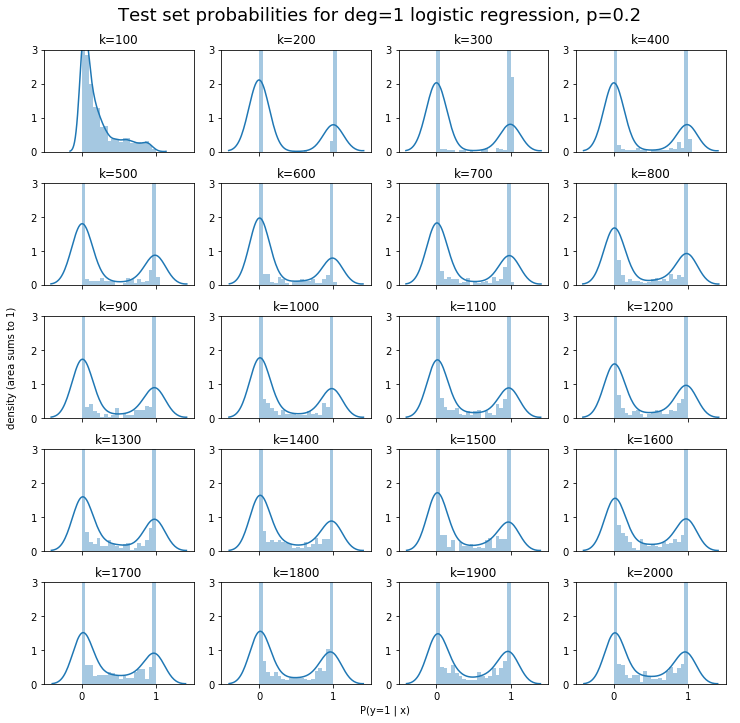

In [80]:
build_prob_plot(skew_test_probas[0], "Test set probabilities for deg=1 logistic regression, p=0.2")

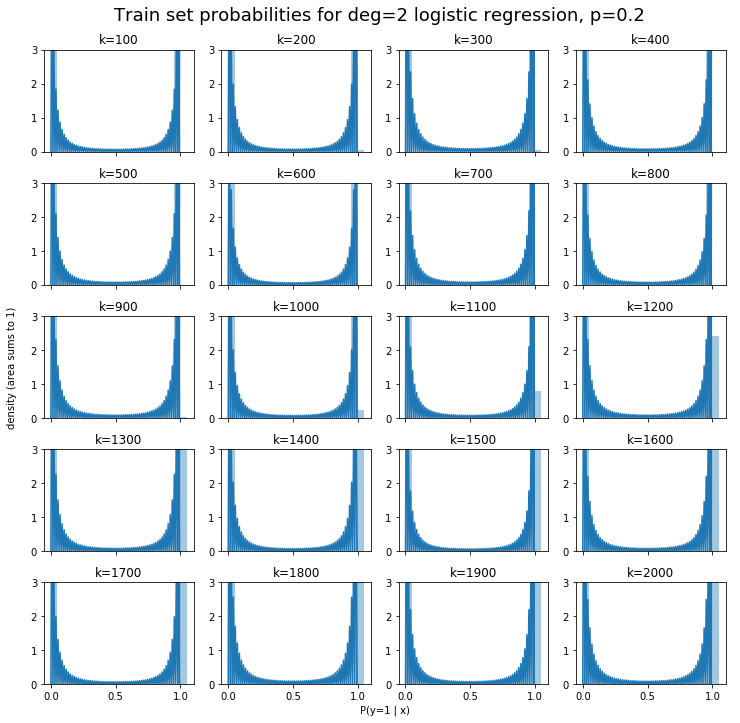

In [81]:
build_prob_plot(skew_train_probas[1], "Train set probabilities for deg=2 logistic regression, p=0.2")

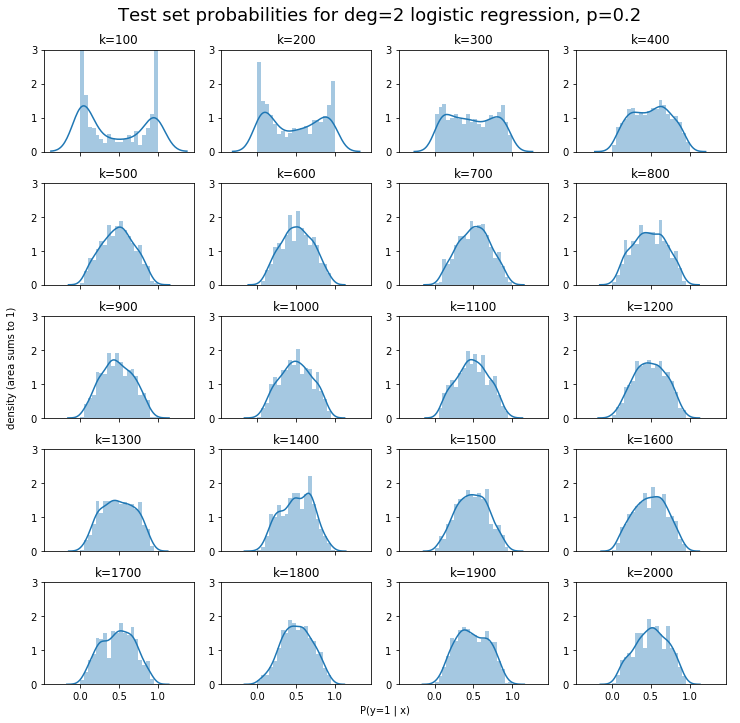

In [82]:
build_prob_plot(skew_test_probas[1], "Test set probabilities for deg=2 logistic regression, p=0.2")

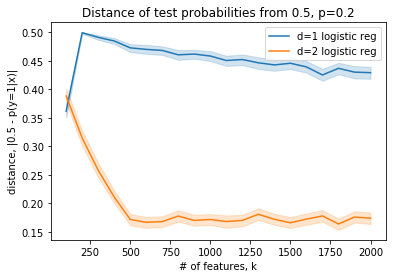

In [88]:
df = pd.DataFrame()
x = []
base_diffs = []
poly_diffs = []
for idx, k in enumerate(range(100, 2001, 100)):
    x = x + [k] * 500
    base_diffs.extend(list(np.abs(0.5 - skew_test_probas[0][idx])))
    poly_diffs.extend(list(np.abs(0.5 - skew_test_probas[1][idx])))

df['x'] = x
df['d1_diff'] = base_diffs
df['d2_diff'] = poly_diffs

sns.lineplot(x='x', y='d1_diff', data=df, label="d=1 logistic reg")
sns.lineplot(x='x', y='d2_diff', data=df, label="d=2 logistic reg")
plt.ylabel("distance, |0.5 - p(y=1|x)|")
plt.xlabel("# of features, k")
plt.title("Distance of test probabilities from 0.5, p=0.2")
plt.show()